<center><h1 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">House Price Prediction 🏡</h1></center>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler , OrdinalEncoder , OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso , Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,ExtraTreesRegressor,VotingRegressor,StackingRegressor
from sklearn.model_selection import GridSearchCV , train_test_split, cross_val_score, learning_curve
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from category_encoders import TargetEncoder
import joblib
import mlflow

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Loading Data</h1>

In [3]:
df = pd.read_csv("Data/train.csv")
df_test  = pd.read_csv("Data/test.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">EDA</h1>

In [4]:
df.shape

(1460, 81)

In [5]:
num_cols = list(df.describe().columns)
cat_cols = list(set(df.columns) - set(num_cols))
print('num_cols:', len(num_cols), ' cat_cols:',len(cat_cols))

num_cols: 38  cat_cols: 43


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Feature Engineering</h1>

### **Columns to Drop and Reasons:**

1. **Utilities**:  
   - **Reason**: 99% of the data is "AllPub" (all public utilities), making the column low in variance and potentially uninformative.

2. **Condition2**:  
   - **Reason**: Used only when there's more than one proximity condition. 99% of the data is "Norm" (Normal), making it less informative compared to `Condition1`.

3. **LowQualFinSF**:  
   - **Reason**: Represents low-quality finished square feet, with 1,434 out of 1,460 values being zero. It likely contributes little to predicting house prices.

4. **BsmtFinType2** and **BsmtFinSF2**:  
   - **Reason**: These represent a second type of finished area in the basement, which is less common. `BsmtFinType1` and `BsmtFinSF1` likely capture most of the relevant information.

5. **3SsnPorch**:  
   - **Reason**: Represents three-season porch area. With 1,437 out of 1,460 values being zero, this feature is rare and can be combined with other porch-related features.

6. **PoolArea** and **PoolQC**:  
   - **Reason**: Pools are rare in the dataset (1,453 values are zero), and their impact on price is likely captured by other luxury indicators.

7. **MiscFeature** and **MiscVal**:  
   - **Reason**: These are catch-all categories for miscellaneous features and are likely to have many null values. They may not provide consistent information across houses.
     - **MiscVal**: 1,447 values are zero.

8. **Alley**:  
   - **Reason**: Many houses might not have alley access, resulting in many null values.

9. **Fence**:  
   - **Reason**: Might not be a crucial factor in determining house prices and could have many null values.

10. **FireplaceQu**:  
    - **Reason**: If you keep the `Fireplaces` count, the quality rating (`FireplaceQu`) may be redundant.

11. **GarageYrBlt**:  
    - **Reason**: This might be redundant with other year-related columns such as `YearBuilt` or `YearRemodAdd`.

12. **LandSlope**:  
    - **Reason**: This feature may be captured by `LandContour` and might not add significant additional information.

13. **Street**:  
    - **Reason**: Most streets are likely paved, making this column low in variance.

14. **RoofMatl**:  
    - **Reason**: 98% of the data is "CompShg" (Composite Shingle), making this column low in variance. The style (`RoofStyle`) is likely more important.

15. **Heating**:  
    - **Reason**: 98% of the data is "GasA" (Gas Air), making this column low in variance.

16. **MasVnrType**:  
    - **Reason**: This column has 60% missing values.

17. **MoSold**:  
    - **Reason**: Month sold is considered irrelevant, and there are alternative time-related features available that strongly correlated with it.

---

### **Summary of Reasons for Dropping:**
- **Low Variance**: Most values are the same.
- **High Correlation**: Strongly correlated with other features.
- **Many Null Values**: Significant amount of missing data.
- **Rare Occurrences**: Rare features that might not significantly impact house prices.
- **Redundancy**: Information captured by other features.

In [8]:
cols_drop=['Id','Utilities', 'Condition2', 'LowQualFinSF', 'BsmtFinType2', 'BsmtFinSF2', '3SsnPorch',
        'PoolArea', 'PoolQC', 'MiscFeature','MiscVal', 'Alley', 'Fence', 'FireplaceQu','GarageYrBlt',
        'LandSlope', 'Street', 'RoofMatl', 'Heating', 'MiscVal', 'MasVnrType', 'MoSold']
df = df.drop(columns=cols_drop)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Reg,Lvl,Inside,CollgCr,Norm,1Fam,...,TA,Y,0,61,0,0,2008,WD,Normal,208500
1,20,RL,80.0,9600,Reg,Lvl,FR2,Veenker,Feedr,1Fam,...,TA,Y,298,0,0,0,2007,WD,Normal,181500
2,60,RL,68.0,11250,IR1,Lvl,Inside,CollgCr,Norm,1Fam,...,TA,Y,0,42,0,0,2008,WD,Normal,223500
3,70,RL,60.0,9550,IR1,Lvl,Corner,Crawfor,Norm,1Fam,...,TA,Y,0,35,272,0,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,IR1,Lvl,FR2,NoRidge,Norm,1Fam,...,TA,Y,192,84,0,0,2008,WD,Normal,250000


- **Time Data**: Transform it into more suitable format for our model.

In [9]:
df['HouseAge'] = 2024 - df['YearBuilt']
df['YearsSinceRemodAdd'] = 2024 - df['YearRemodAdd']
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,YrSold,SaleType,SaleCondition,SalePrice,HouseAge,YearsSinceRemodAdd
0,60,RL,65.0,8450,Reg,Lvl,Inside,CollgCr,Norm,1Fam,...,0,61,0,0,2008,WD,Normal,208500,21,21
1,20,RL,80.0,9600,Reg,Lvl,FR2,Veenker,Feedr,1Fam,...,298,0,0,0,2007,WD,Normal,181500,48,48
2,60,RL,68.0,11250,IR1,Lvl,Inside,CollgCr,Norm,1Fam,...,0,42,0,0,2008,WD,Normal,223500,23,22
3,70,RL,60.0,9550,IR1,Lvl,Corner,Crawfor,Norm,1Fam,...,0,35,272,0,2006,WD,Abnorml,140000,109,54
4,60,RL,84.0,14260,IR1,Lvl,FR2,NoRidge,Norm,1Fam,...,192,84,0,0,2008,WD,Normal,250000,24,24


In [10]:
cols_drop = ['YrSold', 'YearBuilt', 'YearRemodAdd']
df = df.drop(columns=cols_drop)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SaleType,SaleCondition,SalePrice,HouseAge,YearsSinceRemodAdd
0,60,RL,65.0,8450,Reg,Lvl,Inside,CollgCr,Norm,1Fam,...,Y,0,61,0,0,WD,Normal,208500,21,21
1,20,RL,80.0,9600,Reg,Lvl,FR2,Veenker,Feedr,1Fam,...,Y,298,0,0,0,WD,Normal,181500,48,48
2,60,RL,68.0,11250,IR1,Lvl,Inside,CollgCr,Norm,1Fam,...,Y,0,42,0,0,WD,Normal,223500,23,22
3,70,RL,60.0,9550,IR1,Lvl,Corner,Crawfor,Norm,1Fam,...,Y,0,35,272,0,WD,Abnorml,140000,109,54
4,60,RL,84.0,14260,IR1,Lvl,FR2,NoRidge,Norm,1Fam,...,Y,192,84,0,0,WD,Normal,250000,24,24


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Visualization</h1>

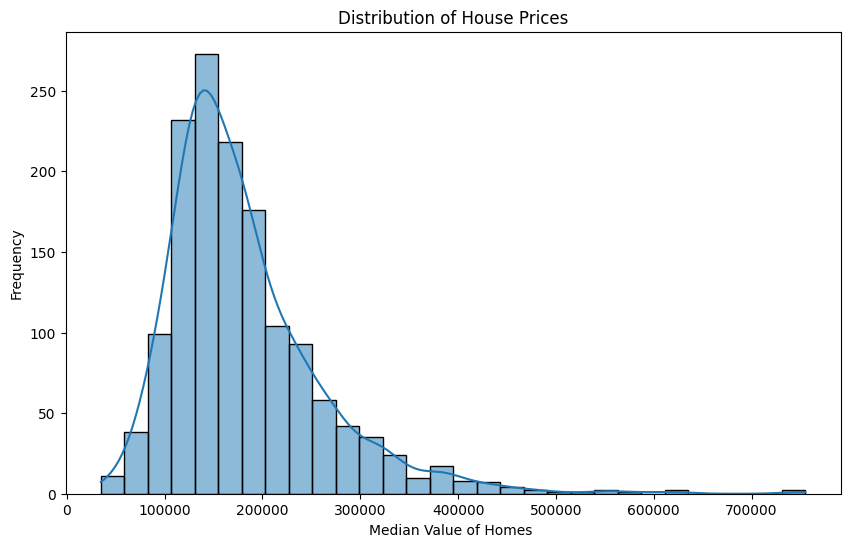

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(df['SalePrice'], kde=True, bins=30)
plt.title('Distribution of House Prices')
plt.xlabel('Median Value of Homes ')
plt.ylabel('Frequency')
plt.show()

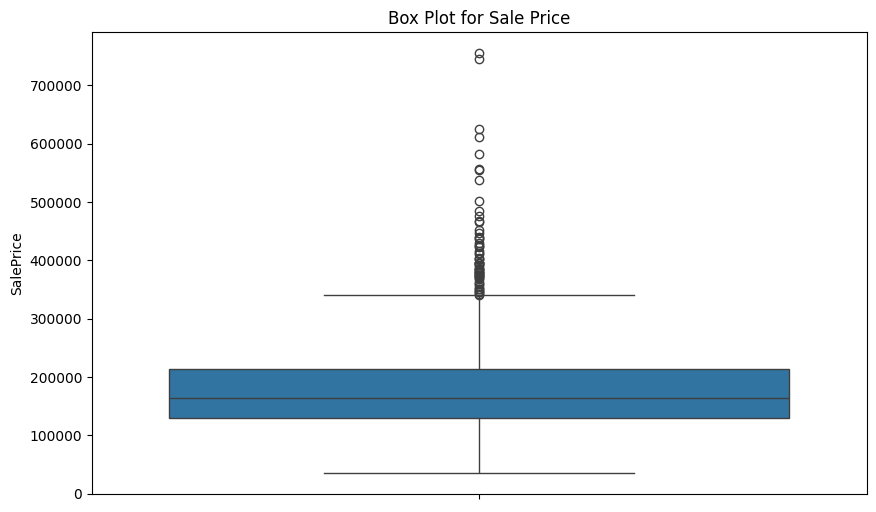

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['SalePrice'])
plt.title('Box Plot for Sale Price')
plt.show()

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Null Values</h1>

In [13]:
null_df = df.isnull().sum()[df.isnull().sum() > 0].sort_values().to_frame().rename(columns={0: "Total Missing values"})
null_df["% of Missing Values"] = round(null_df["Total Missing values"]/len(df)*100, 2)
null_df["Feature Data Type"] = df[null_df.index.tolist()].dtypes
null_df

,Total Missing values,% of Missing Values,Feature Data Type
Electrical,1,0.07,object
MasVnrArea,8,0.55,float64
BsmtCond,37,2.53,object
BsmtQual,37,2.53,object
BsmtFinType1,37,2.53,object
BsmtExposure,38,2.60,object
GarageType,81,5.55,object
GarageFinish,81,5.55,object
GarageCond,81,5.55,object
GarageQual,81,5.55,object


In [14]:
def get_dropped_columns_by_type(df):
    null_df = df.isnull().sum()[df.isnull().sum() > 0].sort_values().to_frame().rename(columns={0: "Total Missing values"})
    
    numeric_cols = df.select_dtypes(include=['number']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    numeric_cols_with_missing = [col for col in null_df.index if col in numeric_cols]
    categorical_cols_with_missing = [col for col in null_df.index if col in categorical_cols]

    return numeric_cols_with_missing, categorical_cols_with_missing

numeric_dropped, categorical_dropped = get_dropped_columns_by_type(df)
print("Numeric columns with missing values:", numeric_dropped)
print("Categorical columns with missing values:", categorical_dropped)

Numeric columns with missing values: ['MasVnrArea', 'LotFrontage']
Categorical columns with missing values: ['Electrical', 'BsmtCond', 'BsmtQual', 'BsmtFinType1', 'BsmtExposure', 'GarageType', 'GarageFinish', 'GarageCond', 'GarageQual']


<h2 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Impute Numeric Values : Mean</h2>

In [15]:
cols_fill_mean = ['MasVnrArea', 'LotFrontage']

for col in cols_fill_mean:
    df[col] = df[col].fillna(round(df[col].mean(), 1))

# imputer = SimpleImputer(strategy="mean")
# df[cols_fill_mean] = imputer.fit_transform(df[cols_fill_mean])

<h2 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Impute Categorical Values : Mode</h2>

In [16]:
df['Electrical'].fillna(df['Electrical'].mode()[0], inplace=True)
df['BsmtQual'].fillna(df['BsmtQual'].mode()[0], inplace=True)
df['BsmtCond'].fillna(df['BsmtCond'].mode()[0], inplace=True)
df['BsmtFinType1'].fillna(df['BsmtFinType1'].mode()[0], inplace=True)
df['BsmtExposure'].fillna(df['BsmtExposure'].mode()[0], inplace=True)
df['GarageType'].fillna(df['GarageType'].mode()[0], inplace=True)
df['GarageFinish'].fillna(df['GarageFinish'].mode()[0], inplace=True)
df['GarageQual'].fillna(df['GarageQual'].mode()[0], inplace=True)
df['GarageCond'].fillna(df['GarageCond'].mode()[0], inplace=True)
df.head()

# from sklearn.impute import KNNImputer
# knn_imputer = KNNImputer(n_neighbors=5)  # We can adjust n_neighbors
# df[cols_fill_knn] = knn_imputer.fit_transform(df[cols_fill_knn])

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SaleType,SaleCondition,SalePrice,HouseAge,YearsSinceRemodAdd
0,60,RL,65.0,8450,Reg,Lvl,Inside,CollgCr,Norm,1Fam,...,Y,0,61,0,0,WD,Normal,208500,21,21
1,20,RL,80.0,9600,Reg,Lvl,FR2,Veenker,Feedr,1Fam,...,Y,298,0,0,0,WD,Normal,181500,48,48
2,60,RL,68.0,11250,IR1,Lvl,Inside,CollgCr,Norm,1Fam,...,Y,0,42,0,0,WD,Normal,223500,23,22
3,70,RL,60.0,9550,IR1,Lvl,Corner,Crawfor,Norm,1Fam,...,Y,0,35,272,0,WD,Abnorml,140000,109,54
4,60,RL,84.0,14260,IR1,Lvl,FR2,NoRidge,Norm,1Fam,...,Y,192,84,0,0,WD,Normal,250000,24,24


In [17]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'ScreenPorch', 'SaleType', 'SaleCondition', 'SalePrice', 'HouseAge',
       'YearsSinceRemodAdd'],
      dtype='object')

In [18]:
cols = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
        'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType',
        'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st',
        'Exterior2nd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
        'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', 'Electrical',
        '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
        'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
        'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
        'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
        'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
        'ScreenPorch', 'SaleType', 'SaleCondition', 'SalePrice', 'HouseAge',
        'YearsSinceRemodAdd']


def value_count(df, cols):
    for col in cols:
        print(f"Value counts for {col}:")
        print(df[col].value_counts())


value_count(df, cols)

Value counts for MSSubClass:
MSSubClass
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: count, dtype: int64
Value counts for MSZoning:
MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64
Value counts for LotFrontage:
LotFrontage
70.0     329
60.0     143
80.0      69
50.0      57
75.0      53
        ... 
182.0      1
160.0      1
152.0      1
153.0      1
46.0       1
Name: count, Length: 110, dtype: int64
Value counts for LotArea:
LotArea
7200     25
9600     24
6000     17
10800    14
8400     14
         ..
10652     1
12968     1
11924     1
14260     1
9550      1
Name: count, Length: 1073, dtype: int64
Value counts for LotShape:
LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64
Value counts for LandContour:
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
N

In [19]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SaleType,SaleCondition,SalePrice,HouseAge,YearsSinceRemodAdd
0,60,RL,65.0,8450,Reg,Lvl,Inside,CollgCr,Norm,1Fam,...,Y,0,61,0,0,WD,Normal,208500,21,21
1,20,RL,80.0,9600,Reg,Lvl,FR2,Veenker,Feedr,1Fam,...,Y,298,0,0,0,WD,Normal,181500,48,48
2,60,RL,68.0,11250,IR1,Lvl,Inside,CollgCr,Norm,1Fam,...,Y,0,42,0,0,WD,Normal,223500,23,22
3,70,RL,60.0,9550,IR1,Lvl,Corner,Crawfor,Norm,1Fam,...,Y,0,35,272,0,WD,Abnorml,140000,109,54
4,60,RL,84.0,14260,IR1,Lvl,FR2,NoRidge,Norm,1Fam,...,Y,192,84,0,0,WD,Normal,250000,24,24


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Categorical Features Encoding</h1>

In [20]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
num_categorical_columns = len(categorical_columns)

print(f"Number of categorical columns: {num_categorical_columns}")
print("Categorical columns are:", categorical_columns)

Number of categorical columns: 30
Categorical columns are: Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')


In [21]:
cols = ['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
        'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st',
        'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
        'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'CentralAir',
        'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish',
        'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']

def value_count(df, cols):
        for col in cols:
                print(f"Value counts for {col}:")
                print(df[col].value_counts())

value_count(df, cols)

Value counts for MSZoning:
MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64
Value counts for LotShape:
LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64
Value counts for LandContour:
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64
Value counts for LotConfig:
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: count, dtype: int64
Value counts for Neighborhood:
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: count, dtype: int64
Value counts for Condition1:
Condition1
Norm   

### Categorical Columns Analysis

1. **Ordinal Encoding (order is meaningful):**
   - **Columns:** `ExterQual`, `ExterCond`, `BsmtQual`, `BsmtCond`,  `HeatingQC`,  `KitchenQual`,  `GarageQual`,  `GarageCond`.  


2. **one-Hot Encoding(order is not meaningful & Low Cardinality (Few Unique Values)):**
   - **Columns:** `MSZoning`,  `LotShape`,  `LandContour`,  `LotConfig`,  `Neighborhood`,  `Condition1`,  `BldgType`,  `HouseStyle`,  `RoofStyle`,  `Foundation`,  `BsmtExposure`,  `BsmtFinType1`,  `Electrical`,  `Functional`,  `GarageType`,  `GarageFinish`,  `PavedDrive`,  `SaleType`.
   - **Encoding Recommendation:** **One-Hot Encoding** is suitable here, as these columns have a limited number of categories, and one-hot encoding will not lead to excessive dimensionality.

3. **Binary Encoding:**
   - `CentralAir`


4. **Special Cases with high-cardinality (many unique vlaues):**
   - **Columns:**  `Neighborhood` , `SaleCondition`,`Exterior1st` , `Exterior2nd`.
   - **Encoding Recommendation:** 
     - **One-Hot Encoding** can still be applied, but it may increase dimensionality significantly. If we find it creates too many columns, we can consider using **Frequency      Encoding** or **Target Encoding**.
     - **Frequency Encoding:** This replaces the category with the frequency of occurrence in the dataset, which can help reduce dimensionality.
     - **Target Encoding:** This replaces the category with the mean of the target variable (if we have a target column). This can be beneficial if we want to capture the effect of the category on the target variable.
     so we will pick `Target Encoding`.

In [22]:
# Ordinal Encoding
ordinal_features = ['ExterQual', 'ExterCond', 'BsmtQual','BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[ordinal_features] = ordinal_encoder.fit_transform(df[ordinal_features])

#mapping binary feature 'CentralAir' (Y/N to 1/0)
mapping = {'Y': 1, 'N': 0}
df['CentralAir'] = df['CentralAir'].map(mapping)

#high cardinality features for target encoding(we do target encoding before one-hot encoding)
high_cardinality_features = ['Neighborhood','Exterior1st', 'Exterior2nd', 'SaleCondition']
target_encoder = TargetEncoder()
df[high_cardinality_features] = target_encoder.fit_transform(df[high_cardinality_features], df['SalePrice'])

# OneHot Encoding
onehot_features = ['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Condition1', 'BldgType', 'HouseStyle',
                'RoofStyle', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'Electrical', 'Functional',
                'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType']
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
onehot_encoded = onehot_encoder.fit_transform(df[onehot_features])
onehot_columns = onehot_encoder.get_feature_names_out(onehot_features)

df = pd.concat([df.drop(columns=onehot_features), pd.DataFrame(onehot_encoded, columns=onehot_columns, index=df.index)], axis=1)
df = df.drop('SaleCondition', axis=1, errors='ignore')

#handle missing values by filling with the mean of each column
df = df.fillna(df.mean())
df.head()

,MSSubClass,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,...,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,60,65.0,8450,197965.734807,7,5,213732.900971,214432.460317,196.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,20,80.0,9600,197643.209810,6,8,149422.177338,149803.173014,0.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,60,68.0,11250,197965.734807,7,5,213732.900971,214432.460317,162.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,70,60.0,9550,209344.287867,7,5,149841.645891,164108.128685,0.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,60,84.0,14260,318453.591177,8,5,213732.900971,214432.460317,350.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


The values in columns like `Exterior2nd` that we have applied **Target Encoding** to (214432.460317, 149803.173014, ....) caused by :

- As **Target Encoding** assigns the mean value of the target variable (`SalePrice`) to each category of a high cardinality feature.
- For example, if a certain category of `Exterior2nd` (like 'VinylSd') is generally associated with houses having a higher price, the target encoder assigns the **average `SalePrice`** for that category to every occurrence of that category in the dataset.
- Since `SalePrice` values range between 0 and 20,000 , the encoded values for features like `Exterior2nd` are the average of those `SalePrice` values, resulting in values like 214432 or 149803 . 

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Spliting & Scaling Data</h1>

In [23]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
X_train, X_cv, y_train, y_cv = train_test_split(X_scaled, y, test_size=0.15, random_state=42)

print("Training set shape:", X_train.shape)
print("Cross-validation set shape:", X_cv.shape)

Training set shape: (1241, 135)
Cross-validation set shape: (219, 135)


In [24]:
y_train.head()

984    126000
777    142500
707    254000
598    217500
874     66500
Name: SalePrice, dtype: int64

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Models Building</h1>



### **Understanding Model Selection: No Free Lunch Theorem**

When starting with no assumptions about the data, there’s no reason to prefer one model over another, as described by the **No Free Lunch (NFL) theorem**. However, for our case, we can rule out certain models based on the dataset's characteristics.

---

### **Models to Consider**:

1. **Lasso & Ridge Regression**:
   - **Lasso**: Ideal for feature selection by shrinking irrelevant coefficients to zero, great for high-dimensional data and reducing overfitting. ✅
   - **Ridge**: Similar but doesn't set coefficients to zero, effective for handling multicollinearity and improving generalization. ✅

2. **Random Forest**:
   - Reduces overfitting by averaging multiple trees, handles non-linear relationships, and is robust to outliers. ✅

3. **Gradient Boosting**:
   - A powerful boosting algorithm that combines weak learners to handle complex, non-linear relationships. Strong performer. ✅

4. **XGBoost (XGB)**:
   - Highly efficient, handles missing data, captures non-linearity, and is flexible for large datasets. A top performer in competitions. ✅

5. **Extra Trees**:
   - Similar to Random Forest but uses more randomness in feature splitting. It’s faster and generally performs well. ✅

---

### **Models to Use with Caution**:

1. **Linear Regression**:
   - Simple and interpretable, but assumes linear relationships. In this case, our dataset likely has complex, non-linear interactions. ❌

2. **Support Vector Regression (SVR)**:
   - Can capture non-linear relationships, but is slow and doesn’t scale well to large datasets. ❌

3. **K-Nearest Neighbors (KNN)**:
   - Simple and non-parametric, but suffers in high-dimensional spaces and is computationally expensive for large datasets. ❌

4. **Multi-Layer Perceptron (MLP)**:
   - Neural networks can capture non-linearity, but often underperform on tabular data compared to tree-based models. ❌

5. **Decision Trees**:
   - Can capture non-linear relationships but prone to overfitting, especially with deeper trees. Use with caution. ❓

6. **AdaBoost**:
   - Combines weak learners to form a strong model, but may not outperform more sophisticated models like Random Forest or Gradient Boosting in large datasets. Worth trying. ❓

---

### **Conclusion**:

#### **Top Models to Focus On**:
- **XGBoost**: Strong performance and flexible, especially in larger datasets.
- **Random Forest**: Reliable and good at capturing complex patterns.
- **Gradient Boosting**: High potential for strong results.
- **Extra Trees**: Fast and a great alternative to Random Forest.

#### **Models to Avoid**:
- **KNN**: Too computationally expensive and sensitive to high-dimensionality.
- **SVR**: Slow and doesn’t scale well for larger datasets.
- **Linear Regression**: Too simplistic for this problem.
- **MLP**: Underperforms on tabular data; other models are better suited.

In [20]:
#iitialize the list to store results
results = []

#list of models
models = [
    ('Lasso', Lasso(alpha=.01, tol=.03)),
    ('Ridge', Ridge(alpha = 0.0001, fit_intercept=False)),
    ('Decision Tree', DecisionTreeRegressor(max_depth=80)),
    ('Random Forest', RandomForestRegressor(n_estimators=100,max_depth=15, criterion='absolute_error', min_samples_split=10)),
    ('AdaBoost', AdaBoostRegressor(n_estimators=100, learning_rate=.1)),
    ('XGB', XGBRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor(n_estimators=200,learning_rate=0.1, loss='huber', max_depth=3, subsample=0.9)),
    ('Extra Trees', ExtraTreesRegressor(n_estimators=200,max_depth=12, criterion='absolute_error', bootstrap=False))
]

def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_cv_pred = model.predict(X_cv)
    
    mse = mean_squared_error(y_cv, y_cv_pred)
    mae = mean_absolute_error(y_cv, y_cv_pred)
    r2 = r2_score(y_cv, y_cv_pred)
    
    rmse = np.sqrt(mse)
    results.append([model_name, mse, mae, r2, rmse])

for model_name, model in models:
    evaluate_model(model, model_name)

results_df = pd.DataFrame(results, columns=["Model", "MSE", "MAE", "R2", "RMSE"])
results_df

,Model,MSE,MAE,R2,RMSE
0,Lasso,1.129489e+09,1.988293e+04,0.860876,3.360788e+04
1,Ridge,3.168559e+14,1.222722e+06,-39027.550304,1.780045e+07
2,Decision Tree,1.126959e+09,2.165115e+04,0.861187,3.357021e+04
3,Random Forest,9.177558e+08,1.723453e+04,0.886956,3.029448e+04
4,AdaBoost,1.243160e+09,2.295630e+04,0.846874,3.525847e+04
5,XGB,6.234828e+08,1.601357e+04,0.923203,2.496964e+04
6,Gradient Boosting,7.052702e+08,1.515490e+04,0.913129,2.655692e+04
7,Extra Trees,8.622870e+08,1.725284e+04,0.893788,2.936472e+04


*  **XGB** , **Gradient Boosting , ExtraTree** have almost **highest R2** &  **lowest MAE,MSE,RMSE** 

In [21]:
GradientBoosting = GradientBoostingRegressor(n_estimators=200,learning_rate=0.1, loss='huber', max_depth=3, subsample=0.9)

GradientBoosting.fit(X_train, y_train)
y_train_pred_GradientBoosting = GradientBoosting.predict(X_train)
y_cv_pred_GradientBoosting = GradientBoosting.predict(X_cv)

mse_cv = mean_squared_error(y_cv, y_cv_pred_GradientBoosting)
mae_cv = mean_absolute_error(y_cv, y_cv_pred_GradientBoosting)
r2_cv = r2_score(y_cv, y_cv_pred_GradientBoosting)
rmse_cv = np.sqrt(mse_cv)

results_cv_df = pd.DataFrame({
    'Actual Values': y_cv.values,
    'Predicted Values': y_cv_pred_GradientBoosting
})

print(f"MSE: {mse_cv}, MAE: {mae_cv}, R2: {r2_cv}, RMSE: {rmse_cv}")
results_cv_df.head(10)

MSE: 781001125.6773056, MAE: 16189.37862479002, R2: 0.9038006154585282, RMSE: 27946.39736490744


,Actual Values,Predicted Values
0,154500,139804.579150
1,325000,341998.383946
2,115000,111398.277488
3,159000,156302.071400
4,315500,310212.885418
5,75500,77428.749488
6,311500,233883.052865
7,146000,141139.327963
8,84500,75539.269877
9,135500,140087.150458


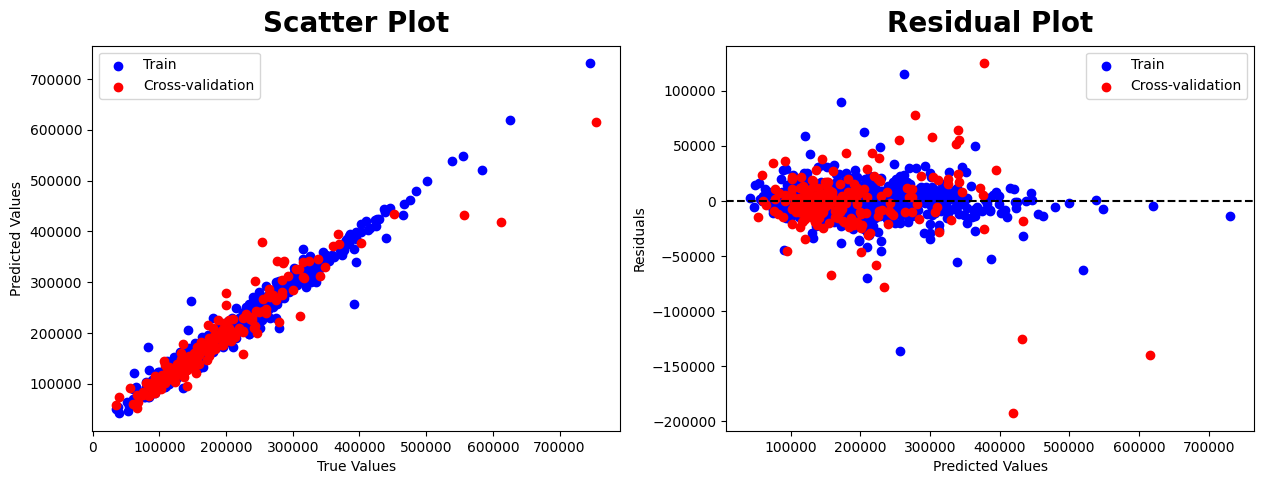

In [22]:
plt.figure(figsize=(15, 5))

#scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_GradientBoosting, color='blue', label='Train')
plt.scatter(y_cv, y_cv_pred_GradientBoosting, color='red', label='Cross-validation')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('Scatter Plot', fontweight="black", size=20, pad=10)

#residual plot
plt.subplot(1, 2, 2)
plt.scatter(y_train_pred_GradientBoosting, y_train_pred_GradientBoosting - y_train, color='blue', label='Train')
plt.scatter(y_cv_pred_GradientBoosting, y_cv_pred_GradientBoosting - y_cv, color='red', label='Cross-validation')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.title('Residual Plot', fontweight="black", size=20, pad=10)
plt.show()

<div style=" background-color: ##F0E68C ; font-size:100%; text-align:left">

**As Gradient Bossting Regressor , Extra Tree Regressor & XGBRegressor are the most suitable models in our case so i decided to do hyperparameter tunning for them and also do ensmbling for them too**

<h2 style="font-family: 'Times New Roman'; letter-spacing: 0.03em;">HyperParameter Tunning </h2>

<h2 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">GridSearchCV</h2>

In [634]:
results = []

param_grid_etr = {
    'n_estimators': [50, 100, 200],
    'max_depth': [12, 13, 14],
    'criterion': ['absolute_error', 'poisson', 'squared_error'],
    'bootstrap': [False, True]
}

grid_search_etr = GridSearchCV(ExtraTreesRegressor(), param_grid_etr, cv=4, scoring='neg_mean_absolute_error')
grid_search_etr.fit(X_train, y_train)

print(f"Best parameters for ExtraTrees: {grid_search_etr.best_params_}")
print(f"Best score for ExtraTrees: {-grid_search_etr.best_score_}")

best_etr = grid_search_etr.best_estimator_
y_cv_pred_best_etr = best_etr.predict(X_cv)

mae_best_etr = mean_absolute_error(y_cv, y_cv_pred_best_etr)
r2_best_etr = r2_score(y_cv, y_cv_pred_best_etr)
mse_best_etr = mean_squared_error(y_cv, y_cv_pred_best_etr)
rmse_best_etr = np.sqrt(mse_best_etr)
results.append(['Extra Trees Regressor (Tuned)', mse_best_etr,mae_best_etr, r2_best_etr, rmse_best_etr])


param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'subsample': [0.8, 0.9]
}

grid_search_gb = GridSearchCV(GradientBoostingRegressor(), param_grid_gb, cv=4, scoring='neg_mean_absolute_error')
grid_search_gb.fit(X_train, y_train)

print(f"Best parameters for Gradient Boosting: {grid_search_gb.best_params_}")
print(f"Best score for Gradient Boosting: {-grid_search_gb.best_score_}")

best_gb = grid_search_gb.best_estimator_
y_cv_pred_best_gb = best_gb.predict(X_cv)

mae_best_gb = mean_absolute_error(y_cv, y_cv_pred_best_gb)
r2_best_gb = r2_score(y_cv, y_cv_pred_best_gb)
mse_best_gb = mean_squared_error(y_cv, y_cv_pred_best_gb)
rmse_best_gb = np.sqrt(mse_best_gb)

results.append(['Gradient Boosting Regressor (Tuned)',mse_best_gb, mae_best_gb, r2_best_gb, rmse_best_gb])

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.1],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(XGBRegressor(), param_grid_xgb, cv=4, scoring='neg_mean_absolute_error')
grid_search_xgb.fit(X_train, y_train)

print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")
print(f"Best score for XGBoost: {-grid_search_xgb.best_score_}")

best_xgb = grid_search_xgb.best_estimator_
y_cv_pred_best_xgb = best_xgb.predict(X_cv)

mae_best_xgb = mean_absolute_error(y_cv, y_cv_pred_best_xgb)
r2_best_xgb = r2_score(y_cv, y_cv_pred_best_xgb)
mse_best_xgb = mean_squared_error(y_cv, y_cv_pred_best_xgb)
rmse_best_xgb = np.sqrt(mse_best_xgb)

results.append(['XGBoost Regressor (Tuned)', mse_best_xgb,mae_best_xgb, r2_best_xgb, rmse_best_xgb])

results_df = pd.DataFrame(results, columns=["Model", "MSE", "MAE", "R2", "RMSE"])
results_df

Best parameters for ExtraTrees: {'bootstrap': True, 'criterion': 'poisson', 'max_depth': 14, 'n_estimators': 200}
Best score for ExtraTrees: 17326.578105185177

Best Extra Trees after Grid Search:
R2 score: 0.8976836757704153
MAE: 16564.79213118695
MSE: 830661908.9025542
RMSE: 28821.20588911148
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Best score for Gradient Boosting: 15813.569036252851

Best Gradient Boosting after Grid Search:
R2 score: 0.9164085970562826
MAE: 15985.831872700774
MSE: 678642385.3662382
RMSE: 26050.765542805806
Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best score for XGBoost: 15926.72735642171

Best XGBoost after Grid Search:
R2 score: 0.919291014646011
MAE: 15328.972959474886
MSE: 655241285.7336365
RMSE: 25597.68125697397
                                 Model           MSE           MAE        R2  \
0        Extra Trees R

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Ensemble Learning</h1>

<h3 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Stacking Regressor</h3>

In [28]:
base_models = [
    ('extra_trees', best_etr),      
    ('gradient_boosting', best_gb),  
    ('xgboost', best_xgb)            
]

#define the stacking regressor with a linear regression meta model
stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(), # we test models like Lasso , Ridge and others and they seems very identical to LR
    cv=4
)

stacked_model.fit(X_train, y_train)
y_cv_pred_stacked = stacked_model.predict(X_cv)

mse_stacked = mean_squared_error(y_cv, y_cv_pred_stacked)
mae_stacked = mean_absolute_error(y_cv, y_cv_pred_stacked)
r2_stacked = r2_score(y_cv, y_cv_pred_stacked)
rmse_stacked = np.sqrt(mse_stacked)

print('\nPerformance of Stacked Model:')
print('R2 score:', r2_stacked)
print('MAE:', mae_stacked)
print('MSE:', mse_stacked)
print('RMSE:', rmse_stacked)

results.append(['Stacked Regressor', mse_stacked,mae_stacked, r2_stacked, rmse_stacked])

results_df = pd.DataFrame(results, columns=["Model", "MSE", "MAE", "R2", "RMSE"])
results_df


Performance of Stacked Model:
R2 score: 0.9215784947623086
MAE: 15253.931116384047
MSE: 636670225.6971488
RMSE: 25232.325015684717


,Model,MSE,MAE,R2,RMSE
0,Linear Regression,6.366702e+08,15253.931116,0.921578,25232.325016
1,Ridge Regression,6.366702e+08,15253.931116,0.921578,25232.325016
2,Lasso Regression,6.366702e+08,15253.931113,0.921578,25232.325016
3,Random Forest,1.409874e+09,17830.350548,0.826340,37548.282282
4,Neural Network,6.356367e+08,14968.163423,0.921706,25211.837334
5,Stacked Regressor,6.366702e+08,15253.931116,0.921578,25232.325016


<h3 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Voting Regressor</h3>

In [638]:
# Define the voting regressor with our trained models
voting_model = VotingRegressor(
    estimators=[
        ('extra_trees', best_etr),         
        ('gradient_boosting', best_gb),    
        ('xgboost', best_xgb)               
    ]
)

voting_model.fit(X_train, y_train)

y_cv_pred_voting = voting_model.predict(X_cv)

mse_voting = mean_squared_error(y_cv, y_cv_pred_voting)
mae_voting = mean_absolute_error(y_cv, y_cv_pred_voting)
r2_voting = r2_score(y_cv, y_cv_pred_voting)
rmse_voting = np.sqrt(mse_voting)

print('\nPerformance of Voting Regressor:')
print('R2 score:', r2_voting)
print('MAE:', mae_voting)
print('MSE:', mse_voting)
print('RMSE:', rmse_voting)

results.append(['Voting Regressor', mse_voting,mae_voting, r2_voting, rmse_voting])

results_df = pd.DataFrame(results, columns=["Model", "MSE", "MAE", "R2", "RMSE"])
results_df


Performance of Voting Regressor:
R2 score: 0.9184021270106928
MAE: 14930.113733127688
MSE: 662457779.3431661
RMSE: 25738.25517285828
               Model           MSE           MAE        R2          RMSE
0  Stacked Regressor  6.669923e+08  15499.203690  0.917844  25826.194845
1   Voting Regressor  6.624578e+08  14930.113733  0.918402  25738.255173


<h3 align="left"><font color=brown>Finally:</font></h3>

### Model Performance Summary

1. **Extra Trees Regressor (Tuned)**
   - **R²**: 0.8977
   - **MAE**: 16,564.79
   - **MSE**: 830,661,908.90
   - **RMSE**: 28,821.21

2. **Gradient Boosting Regressor (Tuned)**
   - **R²**: 0.9164
   - **MAE**: 15,985.83
   - **MSE**: 678,642,385.37
   - **RMSE**: 26,050.77

3. **XGBoost Regressor (Tuned)**
   - **R²**: 0.9193
   - **MAE**: 15,328.97
   - **MSE**: 655,241,285.73
   - **RMSE**: 25,597.68

4. **Stacked Regressor**
   - **R²**: 0.9178
   - **MAE**: 15,499.20
   - **MSE**: 666,992,340.20
   - **RMSE**: 25,826.19

5. **Voting Regressor**
   - **R²**: 0.9184
   - **MAE**: 14,930.11
   - **MSE**: 662,457,779.34
   - **RMSE**: 25,738.26



- **Voting Regressor** has the best performance metrics overall, with the highest R² score and the lowest MAE, MSE, and RMSE among the models. This suggests that it provides the most accurate predictions on average.

- **XGBoost** and **Gradient Boosting** also perform well, but the Voting Regressor outperforms them in all key metrics.

- **Stacked Regressor** is a close second to the Voting Regressor, but it still has slightly higher MAE and RMSE.

In [36]:
extra_trees = ExtraTreesRegressor(bootstrap=True, criterion='poisson', max_depth=14, n_estimators=200)
gradient_boosting = GradientBoostingRegressor(learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.8)
xgboost = XGBRegressor(colsample_bytree=0.8,learning_rate=0.1, max_depth=3, n_estimators=200)

voting_regressor = VotingRegressor(estimators=[
    ('extra_trees', extra_trees),
    ('gradient_boosting', gradient_boosting),
    ('xgboost', xgboost)
])

voting_regressor.fit(X_train, y_train)
y_train_pred_voting = voting_regressor.predict(X_train)
y_cv_pred_voting = voting_regressor.predict(X_cv)

mse_cv = mean_squared_error(y_cv, y_cv_pred_voting)
mae_cv = mean_absolute_error(y_cv, y_cv_pred_voting)
r2_cv = r2_score(y_cv, y_cv_pred_voting)
rmse_cv = np.sqrt(mse_cv)
accuracy = r2_score(y_cv, y_cv_pred_voting)

results_cv_df = pd.DataFrame({
    'Actual Values': y_cv.values,
    'Predicted Values': y_cv_pred_voting
})

print(f"MSE: {mse_cv}, MAE: {mae_cv}, R2: {r2_cv}, RMSE: {rmse_cv}, Accuracy: {accuracy:.2f}%")

results_cv_df.head(10)

MSE: 623109516.7532588, MAE: 15008.30913055578, R2: 0.9232488276356664, RMSE: 24962.161700326735, Accuracy: 0.92%


,Actual Values,Predicted Values
0,154500,141058.671577
1,325000,332321.903302
2,115000,113740.720642
3,159000,156653.199164
4,315500,337129.084453
5,75500,81451.465532
6,311500,222693.261113
7,146000,146558.461272
8,84500,79969.126032
9,135500,129578.627056


**Plot Learning Curves: Plot training and validation error as a function of the training set size or training epochs.**

**Overfitting: Learning curves show a large gap between training and validation error.**

**Underfitting: Learning curves show high error for both training and validation data.**

Training MAE: 7333.6128018678055, Validation MAE: 14997.976448700338
Training MSE: 99556791.1980168, Validation MSE: 687996917.5047345


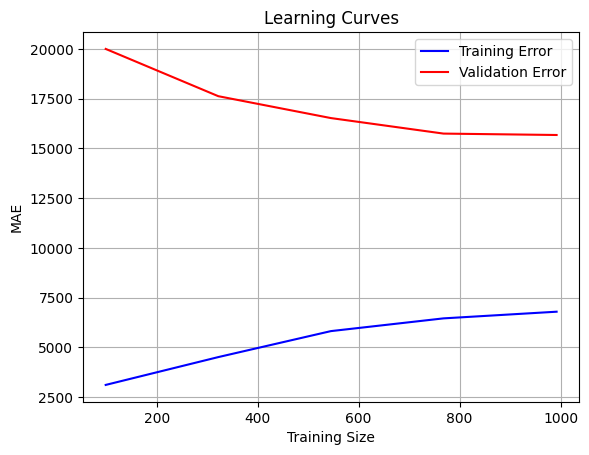

In [27]:
voting_regressor.fit(X_train, y_train)

y_train_pred_voting = voting_regressor.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred_voting)
mae_train = mean_absolute_error(y_train, y_train_pred_voting)

y_cv_pred_voting = voting_regressor.predict(X_cv)
mse_cv = mean_squared_error(y_cv, y_cv_pred_voting)
mae_cv = mean_absolute_error(y_cv, y_cv_pred_voting)

print(f"Training MAE: {mae_train}, Validation MAE: {mae_cv}")
print(f"Training MSE: {mse_train}, Validation MSE: {mse_cv}")

train_sizes, train_scores, test_scores = learning_curve(
voting_regressor, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Training Error', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Validation Error', color='red')
plt.title('Learning Curves')
plt.xlabel('Training Size')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()

In [28]:
cv_scores = cross_val_score(voting_regressor, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

#convert the negative scores back to positive and print them
cv_mae_scores = -cv_scores
print(f"Cross-validation MAE scores: {cv_mae_scores}")
print(f"Mean CV MAE: {cv_mae_scores.mean()}")

Cross-validation MAE scores: [15769.26777193 15162.24274179 18583.9790147  14869.77620979
 13831.23015629]
Mean CV MAE: 15643.299178903539


The model almost suffering from overfitting. This is evident from the significantly lower training mean absolute error (MAE) compared to the validation MAE, as well as the large gap between the training and validation errors in the learning curve. While this overfitting is somewhat expected given the dataset size (1460 samples), combined with a large number of features, it results in a challenging scenario for the model to generalize. Below are the steps taken so far to address this issue:

### 1. Increasing Regularization in Models
Each model in the ensemble can be regularized individually to prevent overfitting:

- **ExtraTreesRegressor:**
   - **Approach**: Decrease `max_depth` and increase `min_samples_split` and `min_samples_leaf` to force trees to capture more generalized patterns.

- **GradientBoostingRegressor:**
   - **Approach**: Lower the `learning_rate`, reduce `max_depth`, and increase `min_samples_split` and `min_samples_leaf` to regularize the model.

- **XGBRegressor:**
   - **Approach**: Add L1 (`alpha`) and L2 (`reg_lambda`) regularization. Also, reduce `max_depth` and adjust `subsample` and `colsample_bytree` to control complexity.


### 5. Adjusting Ensemble Weights
By assigning more weight to models that generalize better (like Gradient Boosting or XGBoost), the ensemble can produce more robust predictions.

These steps focus on regularization, improving model generalization, and reducing overfitting to achieve better performance on unseen data.

In [25]:
extra_trees = ExtraTreesRegressor(bootstrap=True, criterion='poisson', max_depth=10, n_estimators=200, min_samples_split=5, min_samples_leaf=2)
gradient_boosting = GradientBoostingRegressor(learning_rate=0.05, max_depth=3, n_estimators=150,subsample=0.8, min_samples_split=5, min_samples_leaf=2)
xgboost = XGBRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=150, alpha=0.01, reg_lambda=0.01)

voting_regressor = VotingRegressor(estimators=[
    ('extra_trees', extra_trees),
    ('gradient_boosting', gradient_boosting),
    ('xgboost', xgboost)], weights=[1, 2, 2])  # Giving more weight to GBM and XGBoost

voting_regressor.fit(X_train, y_train)
y_train_pred_voting = voting_regressor.predict(X_train)
y_cv_pred_voting = voting_regressor.predict(X_cv)

mse_cv = mean_squared_error(y_cv, y_cv_pred_voting)
mae_cv = mean_absolute_error(y_cv, y_cv_pred_voting)
r2_cv = r2_score(y_cv, y_cv_pred_voting)
rmse_cv = np.sqrt(mse_cv)
accuracy = r2_score(y_cv, y_cv_pred_voting)

results_cv_df = pd.DataFrame({
    'Actual Values': y_cv.values,
    'Predicted Values': y_cv_pred_voting
})

print(f"MSE: {mse_cv}, MAE: {mae_cv}, R2: {r2_cv}, RMSE: {rmse_cv}, Accuracy: {accuracy:.2f}%")

results_cv_df.head(10)

MSE: 685117618.1567606, MAE: 15760.591937488294, R2: 0.9156110138150667, RMSE: 26174.75153954208, Accuracy: 0.92%


,Actual Values,Predicted Values
0,154500,143556.882873
1,325000,330545.092017
2,115000,117551.260959
3,159000,149057.031890
4,315500,321715.834734
5,75500,85194.578872
6,311500,219986.429758
7,146000,141380.030384
8,84500,84877.426032
9,135500,130097.462559


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">MLFLow</h1>

In [27]:
experiment_name = "Models Traning"
mlflow.set_experiment(experiment_name)

2024/11/11 19:52:07 INFO mlflow.tracking.fluent: Experiment with name 'Models Traning' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/917247087764053798', creation_time=1731347527769, experiment_id='917247087764053798', last_update_time=1731347527769, lifecycle_stage='active', name='Models Traning', tags={}>

In [28]:
import mlflow.sklearn
import mlflow.xgboost
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set up MLflow
mlflow.set_experiment("Models Traning")
mlflow.set_tracking_uri("http://localhost:5000")

# List of models with parameters
models = [
    ('Lasso', Lasso(alpha=.01, tol=.03)),
    ('Ridge', Ridge(alpha = 0.0001, fit_intercept=False)),
    ('Decision Tree', DecisionTreeRegressor(max_depth=80)),
    ('Random Forest', RandomForestRegressor(n_estimators=100,max_depth=15, criterion='absolute_error', min_samples_split=10)),
    ('AdaBoost', AdaBoostRegressor(n_estimators=100, learning_rate=.1)),
    ('XGB', XGBRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor(n_estimators=200,learning_rate=0.1, loss='huber', max_depth=3, subsample=0.9)),
    ('Extra Trees', ExtraTreesRegressor(n_estimators=200,max_depth=12, criterion='absolute_error', bootstrap=False))
]


# Results list
results = []

def evaluate_model(model, model_name):
    # Train and predict
    model.fit(X_train, y_train)
    y_cv_pred = model.predict(X_cv)
    
    # Calculate metrics
    mse = mean_squared_error(y_cv, y_cv_pred)
    mae = mean_absolute_error(y_cv, y_cv_pred)
    r2 = r2_score(y_cv, y_cv_pred)
    rmse = np.sqrt(mse)
    
    # Log metrics and parameters to MLflow
    with mlflow.start_run(run_name=model_name):
        # Log model parameters
        mlflow.log_params(model.get_params())
        
        # Log metrics
        mlflow.log_metric("MSE", mse)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("R2", r2)
        mlflow.log_metric("RMSE", rmse)
        
        # Log model to MLflow based on type
        if model_name == 'XGB':
            mlflow.xgboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")
    
    # Store results for summary table
    results.append([model_name, mse, mae, r2, rmse])

# Evaluate and log each model
for model_name, model in models:
    evaluate_model(model, model_name)

# Create a DataFrame with results
results_df = pd.DataFrame(results, columns=["Model", "MSE", "MAE", "R2", "RMSE"])
results_df

2024/11/11 19:52:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/11 19:52:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run Lasso at: http://localhost:5000/#/experiments/917247087764053798/runs/1801ebd5b111456e900584cf154986f7.
2024/11/11 19:52:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/917247087764053798.
2024/11/11 19:52:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/11 19:52:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run Ridge at: http://localhost:5000/#/experiments/917247087764053798/runs/b86565b24e2046dba2c949c511c8b16c.
2024/11/11 19:52:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://loc

,Model,MSE,MAE,R2,RMSE
0,Lasso,1.125273e+09,1.994679e+04,0.861395,3.354509e+04
1,Ridge,3.168529e+14,1.222757e+06,-39027.177520,1.780036e+07
2,Decision Tree,1.521148e+09,2.363744e+04,0.812633,3.900190e+04
3,Random Forest,9.647967e+08,1.732995e+04,0.881162,3.106118e+04
4,AdaBoost,1.174809e+09,2.195416e+04,0.855294,3.427549e+04
5,XGB,6.205484e+08,1.594418e+04,0.923564,2.491081e+04
6,Gradient Boosting,8.475391e+08,1.661902e+04,0.895605,2.911253e+04
7,Extra Trees,8.561357e+08,1.726246e+04,0.894546,2.925980e+04


In [26]:
# Save metrics in a dictionary
metrics = {
    'MSE': mse_cv,
    'MAE': mae_cv,
    'R2': r2_cv,
    'RMSE': rmse_cv,
    'Accuracy': accuracy
}

# Gather parameters in a dictionary for logging
params = {
    'ExtraTreesRegressor': {
        'bootstrap': True,
        'criterion': 'poisson',
        'max_depth': 10,
        'n_estimators': 200,
        'min_samples_split': 5,
        'min_samples_leaf': 2
    },
    'GradientBoostingRegressor': {
        'learning_rate': 0.05,
        'max_depth': 3,
        'n_estimators': 150,
        'subsample': 0.8,
        'min_samples_split': 5,
        'min_samples_leaf': 2
    },
    'XGBRegressor': {
        'colsample_bytree': 0.8,
        'learning_rate': 0.05,
        'max_depth': 3,
        'n_estimators': 150,
        'alpha': 0.01,
        'reg_lambda': 0.01
    },
    'VotingRegressor': {
        'weights': [1, 2, 2]
    }
}

In [ ]:
import mlflow.experiments

experiments = mlflow.experiments
print(experiments)

<module 'mlflow.experiments' from '/home/mando/miniconda3/envs/all/lib/python3.9/site-packages/mlflow/experiments.py'>


In [30]:
experiment_name = "House Price Prediction"
mlflow.set_experiment(experiment_name)

2024/11/11 17:08:25 INFO mlflow.tracking.fluent: Experiment with name 'House Price Prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/887488710017948878', creation_time=1731337705914, experiment_id='887488710017948878', last_update_time=1731337705914, lifecycle_stage='active', name='House Price Prediction', tags={}>

In [31]:

# Start MLflow experiment
mlflow.set_experiment("House Price Prediction")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")

with mlflow.start_run():
    # Log parameters with model names
    for model_name, model_params in params.items():
        mlflow.log_params({f'{model_name}_{k}': v for k, v in model_params.items()})
    
    # Log metrics
    mlflow.log_metrics(metrics)
    
    # Log the model
    mlflow.sklearn.log_model(voting_regressor, "VotingRegressor")

    # Show some predictions in a DataFrame for reference
    results_cv_df = pd.DataFrame({
        'Actual Values': y_cv.values,
        'Predicted Values': y_cv_pred_voting
    })
    print(results_cv_df.head(10))

# Print metrics
print(f"MSE: {mse_cv}, MAE: {mae_cv}, R2: {r2_cv}, RMSE: {rmse_cv}, Accuracy: {accuracy:.2f}%")

2024/11/11 17:08:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/11 17:08:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run abundant-donkey-964 at: http://127.0.0.1:5000/#/experiments/887488710017948878/runs/510f72637bd84a24bd2d581169eafc2d.
2024/11/11 17:08:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/887488710017948878.


   Actual Values  Predicted Values
0         154500     143556.882873
1         325000     330545.092017
2         115000     117551.260959
3         159000     149057.031890
4         315500     321715.834734
5          75500      85194.578872
6         311500     219986.429758
7         146000     141380.030384
8          84500      84877.426032
9         135500     130097.462559
MSE: 685117618.1567606, MAE: 15760.591937488294, R2: 0.9156110138150667, RMSE: 26174.75153954208, Accuracy: 0.92%


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Saving</h1>

In [41]:
joblib.dump(ordinal_encoder, 'Savings/ordinal_encoder.pkl')
joblib.dump(target_encoder, 'Savings/target_encoder.pkl')
joblib.dump(onehot_encoder, 'Savings/onehot_encoder.pkl')
joblib.dump(scaler, 'Savings/scaler.pkl')
joblib.dump(voting_regressor, 'Savings/voting_regressor_model.pkl')

['voting_regressor_model.pkl']

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Test & Save Predictions</h1>

In [715]:
cols_drop = ['Id', 'Utilities', 'Condition2', 'LowQualFinSF', 'BsmtFinType2', 'BsmtFinSF2', '3SsnPorch',
            'PoolArea', 'PoolQC', 'MiscFeature','MiscVal', 'Alley', 'Fence', 'FireplaceQu', 'GarageYrBlt', 
            'LandSlope', 'Street', 'RoofMatl', 'Heating', 'MiscVal', 'MasVnrType', 'MoSold']

df_test = df_test.drop(columns=cols_drop)

df_test['HouseAge'] = 2024 - df_test['YearBuilt']
df_test['YearsSinceRemodAdd'] = 2024 - df_test['YearRemodAdd']
df_test = df_test.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd'])

cols_fill_mean = ['MasVnrArea', 'LotFrontage']
for col in cols_fill_mean:
    df_test[col] = df_test[col].fillna(round(df_test[col].mean(), 1))

fill_mode_columns = ['Electrical', 'BsmtQual', 'BsmtCond', 'BsmtFinType1','BsmtExposure', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for col in fill_mode_columns:
    df_test[col] = df_test[col].fillna(df_test[col].mode()[0])

ordinal_features = ['ExterQual', 'ExterCond', 'BsmtQual','BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']
ordinal_encoder = joblib.load('Savings/ordinal_encoder.pkl')
df_test[ordinal_features] = ordinal_encoder.transform(df_test[ordinal_features])

df_test['CentralAir'] = df_test['CentralAir'].map({'Y': 1, 'N': 0})

high_cardinality_features = ['Neighborhood','Exterior1st', 'Exterior2nd', 'SaleCondition']
target_encoder = joblib.load('Savings/target_encoder.pkl')
df_test[high_cardinality_features] = target_encoder.transform(df_test[high_cardinality_features])

onehot_features = ['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Condition1', 'BldgType', 'HouseStyle',
                'RoofStyle', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'Electrical', 'Functional',
                'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType']
onehot_encoder = joblib.load('Savings/onehot_encoder.pkl')
onehot_encoded = onehot_encoder.transform(df_test[onehot_features])
onehot_columns = onehot_encoder.get_feature_names_out()

df_test = pd.concat([df_test.drop(columns=onehot_features), pd.DataFrame(onehot_encoded, columns=onehot_columns, index=df_test.index)], axis=1)

df_test = df_test.fillna(df_test.mean())

scaler = joblib.load('Savings/scaler.pkl')
X_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)

voting_regressor = joblib.load('Savings/voting_regressor_model.pkl')
predictions = voting_regressor.predict(X_test_scaled)

submission_df = pd.DataFrame({'Id': pd.read_csv('test.csv')['Id'], 'SalePrice': predictions})
submission_df.to_csv('Data/submission.csv', index=False)
print("Predictions saved to 'submission.csv'")

Predictions saved to 'submission.csv'
